In [1]:
import os.path as path
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import csv
from sklearn.utils import shuffle

%matplotlib inline

## Read Driving log

In [2]:
udacity_directory = "../../data/udacity-data/"
track1_directory = "../../data/recovery-data/"
track2_directory = "../../data/track2-data/"
udacity_log_directory = udacity_directory + "driving_log.csv"
track1_log_directory = track1_directory + "driving_log.csv"
track2_log_directory = track2_directory + "driving_log.csv"
udacity_lines = []
track1_lines = []
track2_lines = []
with open(udacity_log_directory,'rt') as f:
    reader = csv.reader(f)
    for line in reader:
        udacity_lines.append(line)
_ = udacity_lines.pop(0)
with open(track1_log_directory,'rt') as f:
    reader = csv.reader(f)
    for line in reader:
        track1_lines.append(line)
_ = track1_lines.pop(0)
with open(track2_log_directory,'rt') as f:
    reader = csv.reader(f)
    for line in reader:
        track2_lines.append(line)
_ = track2_lines.pop(0)

## Preprocessing

In [3]:
new_col, new_row, ch = 16, 64, 3

def translate(image, angle, trans_range):
    rows,cols,_ = image.shape
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    angle = angle + tr_x / trans_range * 2 * 0.2
    tr_y = 40 * np.random.uniform() - 40 / 2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    return image_tr, angle

def adjust_brightness(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # add 0.25 as a constant to avoid solid black images
    rand_value = 0.25 + np.random.uniform()
    image[:,:,2] = image[:,:,2] * rand_value
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    return image

def resize(img, width = 64):
    shape = img.shape
    #crop
    img = img[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    img = cv2.resize(img, (new_row, new_col), interpolation = cv2.INTER_AREA)
    return img

def preprocess_image_train_line(directory, line):
    rand_camera = np.random.randint(3)
    angle = float(line[3])
    shift_angle = 0.0
    
    if rand_camera == 0:
        image_path = directory + line[0].strip()
        shift_angle = 0.0
    if rand_camera == 1:
        image_path = directory + line[1].strip()
        shift_angle = 0.25
    if rand_camera == 2:
        image_path = directory + line[2].strip()
        shift_angle = -0.25
    
    angle = angle + shift_angle    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image, angle = translate(image, angle, 50)
    image = adjust_brightness(image)
    image = resize(image)

    rand_flip = np.random.randint(2)
    if rand_flip == 0:
        image = cv2.flip(image, 1)
        angle = -angle
    
    return image, angle


def training_generator(directories, list_lines, batchsize = 32):
    X_batch = []
    y_batch = []
    
    while True:
        for i in range(batchsize):
            rand_directory = np.random.randint(len(directories))
            directory = directories[rand_directory]
            lines = list_lines[rand_directory]
            
            rand_line = np.random.randint(len(lines))
            
            line = lines[rand_line]
            x, y = preprocess_image_train_line(directory, line)
            
            keep_pr = np.random.randint(4)
            
#             X_batch.append(x)
#             y_batch.append(y)
            if abs(y) > 0.6:            
                X_batch.append(x)
                y_batch.append(y)
            elif keep_pr == 0:
                X_batch.append(x)
                y_batch.append(y)
            else:
                pass
            
        yield np.array(X_batch), np.array(y_batch)

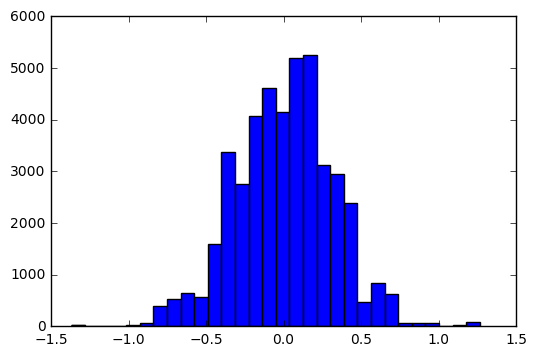

In [4]:
gen = training_generator([udacity_directory], [udacity_lines], 128)
_, y_train = next(gen)
for i in range(50):
    _, y = next(gen)
    y_train = np.concatenate([y_train, y])
plt.hist(y_train, bins=30);

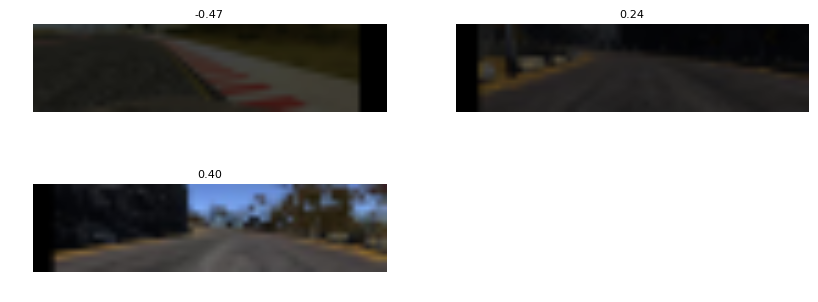

In [5]:
valid_gen = training_generator([udacity_directory, track1_directory, track2_directory], [udacity_lines, track1_lines, track2_lines], 10)
plt.figure(figsize=(10,10))
x, y = next(valid_gen)
for i in range(len(x)):
    plt.subplot(5, 2, i+1) 
    plt.axis('off')
    plt.title("{:.2f}".format(y[i]) , fontsize=8)
    plt.imshow(x[i]) 

### Train model

In [6]:
from keras.models import *
from keras.layers import *
from keras.layers import Conv2D, Flatten, MaxPooling2D, Activation, Dense, Convolution2D, ELU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2
import json

Using TensorFlow backend.


## My simple model

In [7]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=(16,64,3)))
model.add(Conv2D(3, 3, 3, border_mode='valid', input_shape=(16,32,1), activation='relu'))
model.add(MaxPooling2D((4,4),(4,4),'valid'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(ELU())
model.add(Dense(1))


model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 16, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 14, 62, 3)     84          lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 3, 15, 3)      0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 3, 15, 3)      0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

## Comma.ai architecture

In [ ]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=(16,64,3)))
model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(Flatten())
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(512))
model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(1))


model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 16, 64, 3)     0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 4, 16, 16)     3088        lambda_2[0][0]                   
____________________________________________________________________________________________________
elu_2 (ELU)                      (None, 4, 16, 16)     0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 2, 8, 32)      12832       elu_2[0][0]                      
___________________________________________________________________________________________

In [ ]:
print("starting training model")
history = model.fit_generator(training_generator([udacity_directory], 
                                                 [udacity_lines], 
                                                 128),
                    samples_per_epoch= 150*128,
                    nb_epoch=10,
                    verbose=1)

with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

filepath = "./model.h5"
model.save_weights(filepath)

plt.plot(list(history.history['loss']), color = 'g')

starting training model
Epoch 1/10
19193/19200 [============================>.] - ETA: 0s - loss: 0.0664

C:\Users\engah\Anaconda3\envs\python3\lib\site-packages\keras\engine\training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


20375/19200 [===============================] - 37s - loss: 0.0661   
Epoch 2/10
20055/19200 [===============================] - 18s - loss: 0.0559   
Epoch 3/10
20371/19200 [===============================] - 16s - loss: 0.0494   
Epoch 4/10
 8411/19200 [============>.................] - ETA: 8s - loss: 0.0472